In [4]:

import matplotlib
matplotlib.use('Agg')

import os
import json
import sys
import h5py
import itertools
import optparse
import pprint
import traceback
import pylab as pl
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

from pipeline.python.utils import natural_keys, replace_root
from pipeline.python.traces.utils import load_TID, get_metric_set
from pipeline.python.paradigm.align_acquisition_events import get_stimulus_configs, set_pupil_params
pp = pprint.PrettyPrinter(indent=4)


/home/juliana/anaconda/envs/pipeline/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
%matplotlib notebook

In [6]:
def extract_options(options):

    choices_tracetype = ('raw', 'raw_fissa', 'denoised_nmf', 'np_corrected_fissa', 'neuropil_fissa', 'np_subtracted', 'neuropil')
    default_tracetype = 'raw'

    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/nas/volume1/2photon/data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='', help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('--slurm', action='store_true', dest='slurm', default=False, help="set if running as SLURM job on Odyssey")
    parser.add_option('--default', action='store_true', dest='auto', default=False, help="set if want to use all defaults")

    parser.add_option('-t', '--trace-id', action='store', dest='trace_id', default='', help="Trace ID for current trace set (created with set_trace_params.py, e.g., traces001, traces020, etc.)")
    parser.add_option('-T', '--trace-type', type='choice', choices=choices_tracetype, action='store', dest='trace_type', default=default_tracetype, help="Type of timecourse to plot PSTHs. Valid choices: %s [default: %s]" % (choices_tracetype, default_tracetype))

    # Pupil filtering info:
    parser.add_option('--no-pupil', action="store_false",
                      dest="filter_pupil", default=True, help="Set flag NOT to filter PSTH traces by pupil threshold params")
    parser.add_option('-s', '--radius-min', action="store",
                      dest="pupil_radius_min", default=25, help="Cut-off for smnallest pupil radius, if --pupil set [default: 25]")
    parser.add_option('-B', '--radius-max', action="store",
                      dest="pupil_radius_max", default=65, help="Cut-off for biggest pupil radius, if --pupil set [default: 65]")
    parser.add_option('-d', '--dist', action="store",
                      dest="pupil_dist_thr", default=15, help="Cut-off for pupil distance from start, if --pupil set [default: 5]")

    (options, args) = parser.parse_args(options)

    return options

In [8]:
options = ['-D', '/mnt/odyssey', '-i', 'CE077', '-S', '20180425',
        '-A', 'FOV2_zoom1x', '-R', 'blobs_run1', '-t', 'traces001',
        '--no-pupil',
        '-T', 'np_subtracted']

In [9]:
options = extract_options(options)

rootdir = options.rootdir
slurm = options.slurm
if slurm is True and 'coxfs01' not in rootdir:
    rootdir = '/n/coxfs01/2p-data'
animalid = options.animalid
session = options.session
acquisition = options.acquisition
run = options.run
trace_id = options.trace_id
trace_type = options.trace_type
auto = options.auto

filter_pupil = options.filter_pupil
pupil_radius_max = float(options.pupil_radius_max)
pupil_radius_min = float(options.pupil_radius_min)
pupil_dist_thr = float(options.pupil_dist_thr)


In [10]:

# Get acquisition info:
run_dir = os.path.join(rootdir, animalid, session, acquisition, run)


In [11]:

# Load parsed paradigm files:
paradigm_dir = os.path.join(run_dir, 'paradigm')
paradigm_files = sorted([f for f in os.listdir(os.path.join(paradigm_dir, 'files')) if f.endswith('json')], key=natural_keys)

# Load extracted traces:
trace_dir = os.path.join(run_dir, 'traces')
trace_name = [t for t in os.listdir(trace_dir) if os.path.isdir(os.path.join(trace_dir, t)) and trace_id in t][0]
traceid_dir = os.path.join(trace_dir, trace_name)
trace_files = sorted([t for t in os.listdir(os.path.join(traceid_dir, 'files')) if t.endswith('hdf5')], key=natural_keys)
file_names = ["File%03d" % int(i+1) for i in range(len(trace_files))]

In [12]:

# First check whether AUX and TIF files are one-to-one:
with open(os.path.join(paradigm_dir, 'files', paradigm_files[0]), 'r') as fp:
    tmptrials = json.load(fp)
    blocknums = list(set([tmptrials[t]['block_idx'] for t in tmptrials.keys()]))
    if len(blocknums) > 1:
        # More than 1 block found in curr aux file.
        one_to_one = False

        # Load run meta info to get N frames per file (need in order to offset tstamps for tifs):
        runinfo_path = os.path.join(run_dir, '%s.json' % run)
        with open(runinfo_path, 'r') as fr:
            runinfo = json.load(fr)
        nvolumes = runinfo['nvolumes']
        nslices_full = int(round(runinfo['frame_rate']/runinfo['volume_rate']))
        nframes_per_file = nslices_full * nvolumes
        secs_per_file = nframes_per_file / runinfo['volume_rate'] + (1/runinfo['volume_rate'])

    else:
        # Only 1 block found in curr aux file.
        one_to_one = True

if one_to_one is True:
    # Make sure there is an AUX file for each extract-trace file (of which there is 1 per TIF):
    assert len(paradigm_files) == len(trace_files), "Mismatch in N paradigm files (%i) and N trace files (%i)" % (len(paradigm_files), len(trace_files))
    try:
        file_list = [(par, tra) for par, tra in zip(paradigm_files, trace_files)]
        for fname in file_names:
            pidx = paradigm_files.index([f for f in paradigm_files if fname in f or fname.lower() in f][0])
            tidx = trace_files.index([t for t in trace_files if fname in t][0])
            assert pidx == tidx, "Paradigm and Trace files are not sorted properly!"
    except Exception as e:
        print "--- ERROR: Unable to match TIFF files to paradigm files..."
        traceback.print_exc()
        print "----------------------------------------------------------"
        for p, pfile in enumerate(paradigm_files):
            print p, pfile
        for t, tfile in enumerate(trace_files):
            print t, tfile
        print "ABORTING."

#%% CREATE TRIAL dataframe:
trial_dfs = []
for fidx, paradigm_fn in enumerate(sorted(paradigm_files, key=natural_keys)):
    curr_file = file_names[fidx]
    with open(os.path.join(paradigm_dir, 'files', paradigm_fn), 'r') as fp:
        trials = json.load(fp)
    for idx, trial in enumerate(sorted(trials.keys(), key=natural_keys)):
        if trials[trial]['stimuli']['type'] == 'drifting_grating':
            experiment = 'gratings'
            trial_dfs.append(pd.DataFrame({'trial': str(trial),
                                           'file': curr_file,
                                           'block': trials[trial]['block_idx'] + 1,
                                           'stim_on': trials[trial]['stim_on_time_block']/1E3,
                                           'stim_off': trials[trial]['stim_off_time_block']/1E3,
                                           'ori': int(trials[trial]['stimuli']['rotation']),
                                           'sf': trials[trial]['stimuli']['frequency'],
                                           'xpos': trials[trial]['stimuli']['position'][0],
                                           'ypos': trials[trial]['stimuli']['position'][1],
                                           'size': trials[trial]['stimuli']['scale'][0]},
                                           index=[idx]
                                           ))
        else:
            # do sth else:
            experiment = 'images'
            trial_dfs.append(pd.DataFrame({'trial': str(trial),
                                           'file': curr_file,
                                           'block': trials[trial]['block_idx'] + 1,
                                           'stim_on': trials[trial]['stim_on_time_block']/1E3,
                                           'stim_off': trials[trial]['stim_off_time_block']/1E3,
                                           'img': os.path.split(trials[trial]['stimuli']['filepath'])[1],
                                           'xpos': trials[trial]['stimuli']['position'][0],
                                           'ypos': trials[trial]['stimuli']['position'][1],
                                           'size': trials[trial]['stimuli']['scale'][0]}, # int(trials[trial]['stimuli']['name'])},
                                           index=[idx]
                                           ))
TRIALS = pd.concat(trial_dfs, axis=0)


In [13]:
# Get mask info from MASKS.hdf5 in traceid dir:
maskinfo = h5py.File(os.path.join(traceid_dir, 'MASKS.hdf5'), 'r')

trace_dfs = []
for fidx, trace_fn in enumerate(sorted(trace_files, key=natural_keys)):
    curr_file = file_names[fidx]

    # Load extrated TRACES from extracted timecourse mats [T,nrois]:
    traces = h5py.File(os.path.join(traceid_dir, 'files', trace_fn), 'r')
    for sidx, curr_slice in enumerate(traces.keys()):
        print "trace types:", traces[curr_slice]['traces'].keys()

        nr = maskinfo[curr_file][curr_slice]['maskarray'].attrs['nr'] #traces[curr_slice]['masks'].attrs['nr']
        nb = maskinfo[curr_file][curr_slice]['maskarray'].attrs['nb'] #traces[curr_slice]['masks'].attrs['nb']

        roi_list = ['roi%05d' % int(ridx+1) for ridx in range(nr)] #traces[curr_slice]['masks'].attrs['roi_idxs']]
        roi_list.extend(['bg%02d' % int(bidx+1) for bidx in range(nb)]) # Make sure background comps are at END Of list, since indexing thru:

        for ridx, roi in enumerate(roi_list):
#            if len(traces.keys()) > 1:
            trace_dfs.append(pd.DataFrame({'tsec': traces[curr_slice]['frames_tsec'][:], # + fidx*secs_per_file,
                                     'file': curr_file,
                                     'block': fidx + 1,
                                     'slice': curr_slice,
                                     'values': traces[curr_slice]['traces'][trace_type][:, ridx],
                                     'roi': roi_list[ridx]
                                     }))

    traces.close()

DATA = pd.concat(trace_dfs, axis=0)



trace types: [u'neuropil', u'np_subtracted', u'raw']
trace types: [u'neuropil', u'np_subtracted', u'raw']
trace types: [u'neuropil', u'np_subtracted', u'raw']
trace types: [u'neuropil', u'np_subtracted', u'raw']
trace types: [u'neuropil', u'np_subtracted', u'raw']
trace types: [u'neuropil', u'np_subtracted', u'raw']
trace types: [u'neuropil', u'np_subtracted', u'raw']
trace types: [u'neuropil', u'np_subtracted', u'raw']
trace types: [u'neuropil', u'np_subtracted', u'raw']
trace types: [u'neuropil', u'np_subtracted', u'raw']


In [14]:
selected_roi = 'roi00047'

In [17]:
file_id = 3 # this is tmp
blockidx = file_id - 1

#selected_roi = 'roi%05d' % int(roi_id)
#selected_slice = 'Slice%02d' % int(slice_id)
selected_file = 'File%03d' % int(file_id)

# Only grab entries for selected ROI:
roi_df = DATA.loc[DATA['roi'] == selected_roi]

# Only grab a given file, tmp:
file_df = roi_df.loc[roi_df['file'] == selected_file]

#%%
# GET STIM CONFIG dict -- this is created in align_acquisition_events.py
with open(os.path.join(paradigm_dir, 'stimulus_configs.json'), 'r') as f:
    configs = json.load(f)

In [21]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def smooth_traces(trace, frac=0.002):
    '''
    lowess algo (from docs):

    Suppose the input data has N points. The algorithm works by estimating the
    smooth y_i by taking the frac*N closest points to (x_i,y_i) based on their
    x values and estimating y_i using a weighted linear regression. The weight
    for (x_j,y_j) is tricube function applied to abs(x_i-x_j).
    '''
    xvals = np.arange(len(trace))
    filtered = lowess(trace, xvals, is_sorted=True, frac=frac, it=0)
    return filtered[:, 1]


<IPython.core.display.Javascript object>


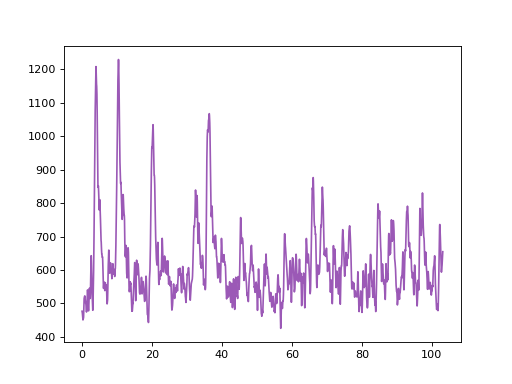

In [23]:
trace = file_df['values'].values
filtered = smooth_traces(trace, frac=0.005)
#fig, ax = pl.subplots(1,1, figsize=(20,2))
pl.figure()
#pl.plot(file_df['tsec'], file_df['values'])
pl.plot(file_df['tsec'], filtered)


In [36]:
df_trace = (filtered - np.mean(filtered)) / np.mean(filtered)

<IPython.core.display.Javascript object>


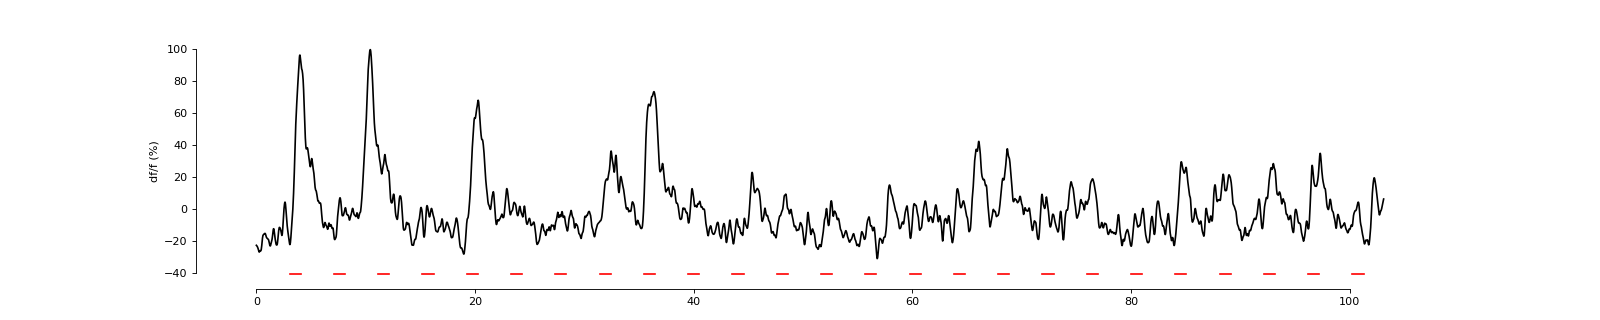

In [48]:
fig, ax = pl.subplots(1,1, figsize=(20,4))
#pl.plot(file_df['tsec'], file_df['values'])
pl.plot(file_df['tsec'], df_trace * 100, 'k')

colorvals = sns.color_palette("hls", len(configs.keys()))

curr_trials_df = TRIALS.loc[TRIALS['block'] == blockidx+1]
stim_bar_loc = df_trace.min()  - 40

dfs = []
for cidx, config_key in enumerate(sorted(configs.keys(), key=natural_keys)):
    stimcolor = 'r' #colorvals[cidx]
    if experiment == 'gratings':
        ori = configs[config_key]['rotation']
        sf = configs[config_key]['frequency']
        xpos = configs[config_key]['position'][0]
        ypos = configs[config_key]['position'][1]
        size = configs[config_key]['scale'][0]
        stimconfig = 'Ori: %.0f, SF: %.2f' % (ori, sf)
        key_trials = curr_trials_df.loc[(curr_trials_df['ori'] == ori) &
                                    (curr_trials_df['sf'] == sf) &
                                    (curr_trials_df['xpos'] == xpos) &
                                    (curr_trials_df['ypos'] == ypos) &
                                    (curr_trials_df['size'] == size)
                                    ]['trial']
    else:
        currimg = os.path.split(configs[config_key]['filepath'])[1]
        currxpos = configs[config_key]['position'][0]
        currypos = configs[config_key]['position'][1]
        currsize = configs[config_key]['scale'][0]
        stimconfig = '%s, pos (%.1f, %.1f), size %.1f' % (str(currimg), currxpos, currypos, currsize)
        key_trials = curr_trials_df.loc[(curr_trials_df['img'] == currimg) &
                                    (curr_trials_df['xpos'] == currxpos) &
                                    (curr_trials_df['ypos'] == currypos) &
                                    (curr_trials_df['size'] == currsize)
                                    ]['trial']


    got_legend = False
    for trial in sorted(key_trials, key=natural_keys): #trials.keys():
        #print trial
        stim_on_sec = float(curr_trials_df.loc[curr_trials_df['trial'] == trial, 'stim_on'])
        stim_off_sec = float(curr_trials_df.loc[curr_trials_df['trial'] == trial, 'stim_off'])
        if got_legend is False:
            pl.plot([stim_on_sec, stim_off_sec], np.array([1,1])*stim_bar_loc, color=stimcolor, label=stimconfig)
            got_legend = True
        else:
            pl.plot([stim_on_sec, stim_off_sec], np.array([1,1])*stim_bar_loc, color=stimcolor, label=None)

#pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine(trim=True, offset=4)
pl.ylabel('df/f (%)')